# Wind Turbine under Yaw Misalignment

In case the wind turbine rotor is not perpendicular to the inflow, its operation and effects on the flow field will be different. In general, it is a quite complicated process. In PyWake, the effects are divided into three sub-effects that are handled invididually:

1. Change of operation ($C_{T,n}$) due to reduced inflow wind speed
2. Reduced thrust, <font style="color:red">$T_n$</font>, due to reduced inflow wind speed normal to the rotor
3. Reduced deficit, <font style="color:#CCCC00">$deficit_{downwind}$</font>, due to misalignment between thrust and downwind direction
4. Deflection of wake deficit, <font style="color:green">$deficit_{deflected}$</font>, due to transversal thrust component reaction

<img src="../_static/wt_in_yaw.svg" alt="drawing" width="700"/>

**Install PyWake if needed**

In [80]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

**First we import some basic Python elements**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import IntSlider

**We also import the site, wind turbines, and engineering wake models necessary for the simulation**

In [9]:
from py_wake.examples.data.hornsrev1 import V80
from py_wake.flow_map import HorizontalGrid
from py_wake.tests.test_files import tfp
from py_wake.wind_farm_models import PropagateDownwind, All2AllIterative
from py_wake.deficit_models import FugaYawDeficit
from py_wake.deflection_models import FugaDeflection, JimenezWakeDeflection
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.flow_map import XYGrid
from py_wake.utils.plotting import setup_plot

wt = V80()
site = Hornsrev1Site()

## Effect 1 - Change of operation due to reduced inflow wind speed

The inflow perpendicular to the rotor is reduced by $cos\theta$.

This means that the pitch and rotor speed setting of the WT will be different. In PyWake, the WT operation (pitch and rotor speed settings) is modeled in terms of the Power and CT curves. If these curves are specified in terms of the wind speed normal to the rotor, then the wind speed must be multiplied by $cos\theta$ before looking up the power and CT.

This is one of two effects modeled by the `SimpleYawModel`, which is an additional model that is applied as default to most PowerCtFunctions, see [here](#SimpleYawModel) for more details.

Note, that below rated rotor speed, the CT curve is typically rather flat and reducing the wind speed has therefore limited effect on the CT value in this region. The power, on the other hand, is limited by the maximum power and therefore only affected in the region below rated wind speed (rated wind speed will increase with yaw misalignment).

Furthermore, misalignment between the thrust force (axial induction) and the inflow leads to higher wind speed at the rotor plane, which also affects the WT operation. To include this effect in PyWake, the `SimpleYawModel` must be replaced by Power and Ct curves a functions of both wind speed and yaw misalignment.

**Power and CT curves for a V80 wind turbine with yaw misalignment modeled by `SimpleYawModel`**

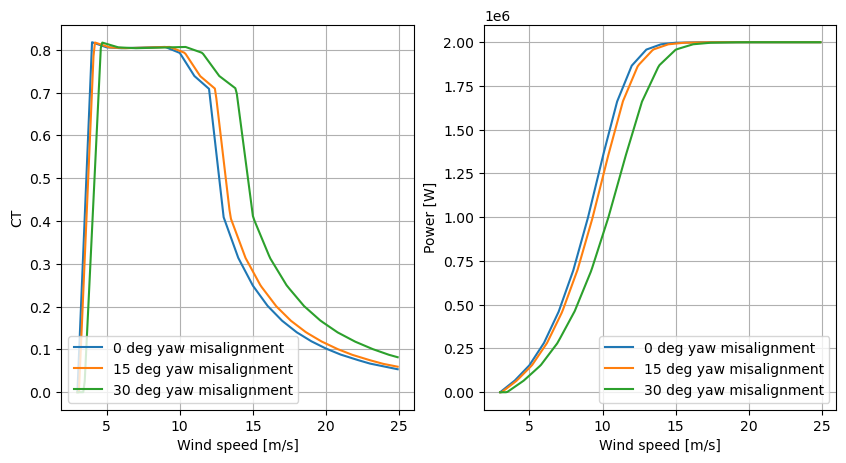

In [3]:
#here we can see an example of the thrust and power curves for different yaw misalignment angles
u = np.arange(3,25,.1)
ax1,ax2 = plt.subplots(1,2, figsize=(10,5))[1]

#looping through different values for yaw angles
for yaw in [0,15,30]:
    ax1.plot(u,wt.ct(u*np.cos(np.deg2rad(yaw))), label='%d deg yaw misalignment'%yaw)
    ax2.plot(u,wt.power(u*np.cos(np.deg2rad(yaw))), label='%d deg yaw misalignment'%yaw)
    
setup_plot(ax=ax1, xlabel='Wind speed [m/s]', ylabel='CT')
setup_plot(ax=ax2, xlabel='Wind speed [m/s]', ylabel='Power [W]')

## Effect 2 - Reduced thrust, $T_n$, due to reduced inflow wind speed normal to the rotor

The thrust force normal to the rotor plane, $T_n$, can be obtained from e.g. BEM or full aeroelastic simulations that includes a model for skew inflow, e.g. HAWC2Aero or HAWC2. These simulations can be precomputed for ranges of wind speed and yaw-misalignment angles.

Alternatively, $T_n$, can be estimated from the normal CT curve, using the wind speed perpendicular to the rotor

\begin{align}
T_n & =\frac{1}{2}\rho C_{T,n} A (U cos\theta)^2
\end{align}

## Effect 3 - Reduced deficit, due to misalignment between $T_n$ and downwind direction

The wake deficit is caused by a reaction to the thrust force, which slows down the inflow. Engineering wake models typically scales with $2a$ which is derived from $C_T$.

In non-aligned inflow, the thrust force that slows down the flow in the mean wind direction is

\begin{align}
T_x & =T_n cos\theta
\end{align}

The thrust coefficient in the down-wind direction, $C_{T,x}$ can then be derived by

\begin{align}
C{T_x} & = \frac{T_x}{T_{max}}
\end{align}

where $T_{max}$ is the thrust force, associated with the maximum possible pressure drop over the rotor, i.e.

\begin{align}
T_{x,max} & = \Delta p A_x = \rho \frac{1}{2} U (U-0) A_x
\end{align}

Here, $A_x = A \cos{\theta}$ is the rotor area projection onto the plane that is perpendicular to the wind.

Finally, we get

\begin{align}
C_{T,x} & = \frac{T_n cos\theta}{\rho \frac{1}{2} U^2 A \cos{\theta}} \\
 & = \frac{T_n}{\rho \frac{1}{2} U^2 A} \\
\end{align}

If $T_n$ is estimated from the normal CT curve, this reduces to:

\begin{align}
C_{T,x} & = \frac{\frac{1}{2}\rho C_{T,n} A (U cos\theta)^2}{\rho \frac{1}{2} U^2 A } \\
 & = C_{T,n} \cos^2{\theta} \\
\end{align}


This is the second effect modeled by the `SimpleYawModel`, which is an additional model that is applied as default to most PowerCtFunctions and is shown below.

### SimpleYawModel

The `SimpleYawModel` is an additional model, which as default is applied by 

- `PowerCtFunction`
- `PowerCtTabular`
- `PowerCtNDTabular`
- `PowerCtXr`
- `CubePowerSimpleCt`

It handles effects 1-3 by:

1. Compute/look up $C_{T,n}$ based on wind speed $U\cos\theta$
2. Returns $C_{T,x} = C_{T,n} \cos^2\theta$

Note that this model should not be used if the Power and CT curves are derived from e.g. HAWC2 simulations with skew inflow 

### `FugaYawDeficit` model
In the  `FugaYawDeficit` model, this effect is modelled implicitly, by combining two sets of look-up tabels, namely `UL` and `UT`. These tables describes the normalized deficit in the downwind, `U` direction caused by a unit forcing in the longitudinal, L, and transveral, T, directions.

This means that the $C_{T,x}$ value in PyWake must be converted (back) to $C_{T,n}$ by

\begin{align}
C_{T,n} & = \frac{C_{T,x}}{ \cos^2{\theta}}
\end{align}



In [4]:
fuga = FugaYawDeficit(tfp + 'fuga/2MW/Z0=0.00001000Zi=00400Zeta0=0.00E+00.nc')
D = 80
R = D/2
x0,x1,y = 1,10,2 #upstream, downstream and crosswind regions to load [D]
xi0 = int(512-x0/(fuga.dx/D))
xi1 = int(512+x1/(fuga.dx/D))+1
yi = int(y/(fuga.dy/D))+1
UL, UT = [-fuga.mirror(v,anti_symmetric=a) for v, a in zip(fuga.load_luts()[:2,0,:yi, xi0:xi1], (False,True))]

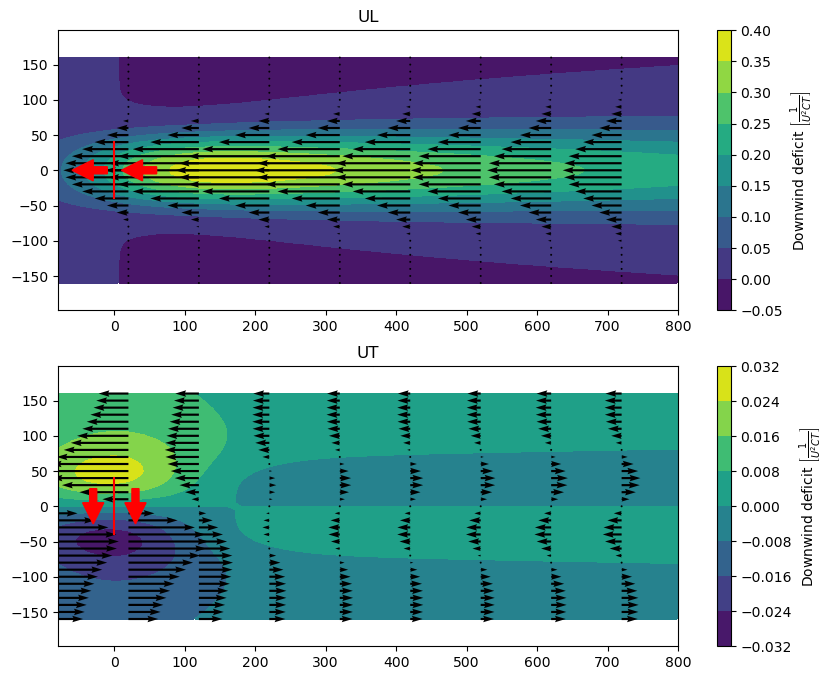

In [5]:
axes = plt.subplots(2,1, figsize=(10,8))[1]
X, Y = np.meshgrid(fuga.x[xi0:xi1], fuga.mirror(fuga.y[:yi], anti_symmetric=True))
wtL = np.array([[0,0],[-D/2,D/2]])
for ax, v, l in zip(axes.flatten(), [UL, UT], ['UL','UT']):
    c = ax.contourf(X, Y, v)
    plt.colorbar(c, ax=ax, label=r'Downwind deficit $\left[\frac{1}{U^2 CT}\right]$')
    s = (slice(None,None,2),slice(None,None,5))
    ax.quiver(X[s], Y[s], -v[s]*(l[0]=='U'), v[s]*(l[0]=='V'))
    ax.plot([0,0],[-D/2,D/2],'r')
    if l[1]=='L':
        ax.arrow(-10,0,-20,0,color='r', width=10,head_length=30)
        ax.arrow(60,0,-20,0,color='r', width=10,head_length=30)
    else:
        ax.arrow(-30,25,0,-20,color='r', width=10,head_length=30)
        ax.arrow(30,25,0,-20,color='r', width=10,head_length=30)
        
    ax.axis('equal')
    ax.set_xlim([-D,10*D])
    ax.set_ylim([-D,D])
    ax.set_title(l) 

**As Fuga is a linear model, the deficit in the downstream direction can simply be calculated by the linear superposition of** `UL` **and** `UT`:

$deficit = (UL \cdot cos\theta + UT \cdot sin\theta) \cdot U \cdot CT$

**You can move the slider below to see the deficit fields for different yaw-misalignment angles**


In [12]:
%matplotlib notebook
def plot(yaw):
    plt.figure(figsize=(10,5))
    theta = np.deg2rad(yaw)
    co, si = np.cos(theta), np.sin(theta)
    deficit = co**2*(UL*co + UT*si)
    c = plt.contourf(X, Y, deficit,20)#, levels=np.arange(-.4,.1,.05))
    plt.colorbar(c, label=r'Downwind deficit $\left[\frac{1}{U^2 CT}\right]$')
    s = (slice(None,None,2),slice(None,None,5))
    plt.quiver(X[s], Y[s], -deficit[s], deficit[s]*0, width=.002, scale=2)
    plt.plot([si*R, -si*R],[-co*R,co*R],'w',label='Rotor',lw=3)
    plt.arrow(-0,0,-100*co,0,color='r', width=5,head_length=10,length_includes_head=True)
    plt.arrow(-0,-0,0,-100*si,color='r', width=5,head_length=10,length_includes_head=True, zorder=32)
    plt.axis('equal')
    plt.xlim([-D,10*D])
    plt.ylim([-D/2,D/2])
    ax.set_title(l) 
    plt.tight_layout()
_ = interact(plot, yaw=IntSlider(min=-90, max=90, step=1, value=20, continuous_update=False))

interactive(children=(IntSlider(value=20, continuous_update=False, description='yaw', max=90, min=-90), Output…

## Effect 4 - Wake deflection due to traversal thrust component reaction

Wake deflection is modeled by a `DeflectionModel`, which modifies the downwind, horizontal crosswind and vertical distance between wind turbines. Here is an example with the JimenezWakeDeflection

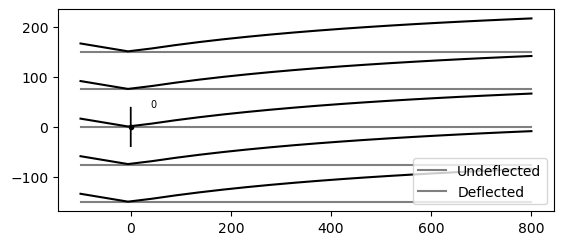

In [13]:
%matplotlib inline
from py_wake.deflection_models import JimenezWakeDeflection
x = np.linspace(-100,800, 20)
y = np.linspace(-150,150,5)
dw,hcw = np.meshgrid(x,y)
plt.plot(dw.T,hcw.T,'grey');
dw_def, hcw_def,dh_def = JimenezWakeDeflection().calc_deflection(
    dw_ijlk=dw.reshape(1,-1,1,1), 
    hcw_ijlk=hcw.reshape(1,-1,1,1), 
    dh_ijlk=dw.reshape(1,-1,1,1)*0,
    D_src_il=np.reshape([80],(1,1)), 
    yaw_ilk=np.reshape([30],(1,1,1)), 
    tilt_ilk=np.reshape([0],(1,1,1)), 
    ct_ilk=8/9)
dw_def, hcw_def = dw_def.reshape(dw.shape), hcw_def.reshape(hcw.shape)
plt.plot(dw_def.T,hcw_def.T,'k')
wt.plot([0],[0],wd=270)
plt.axis('scaled')
plt.legend(['Undeflected','Deflected'], loc='lower right')

<IPython.core.display.Javascript object>


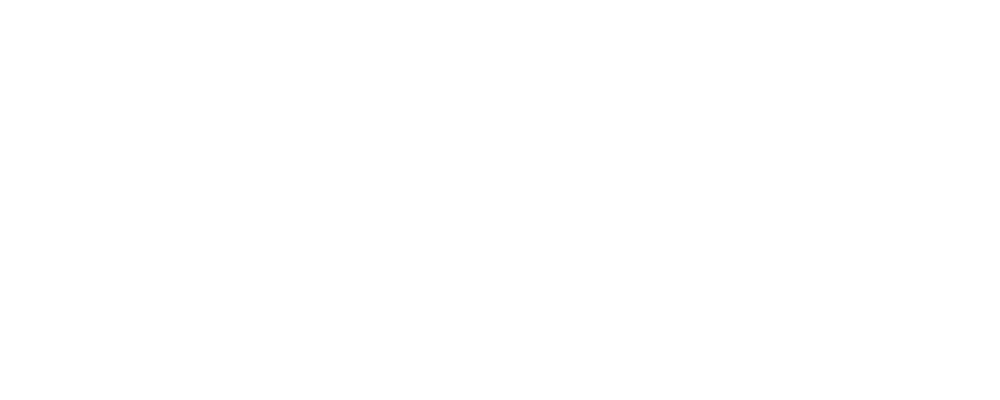

interactive(children=(IntSlider(value=20, continuous_update=False, description='yaw', max=90, min=-90), Output…

In [15]:
%matplotlib notebook
path = tfp + 'fuga/2MW/Z0=0.00001000Zi=00400Zeta0=0.00E+00.nc'
fugaDeficit = FugaYawDeficit(path)
wfm = All2AllIterative(site,wt,fugaDeficit,blockage_deficitModel=fugaDeficit,                       
                       deflectionModel=JimenezWakeDeflection()
                       )
fig = plt.figure(figsize=(10,4))
def plot(yaw):
    plt.figure(figsize=(10,5))
    fm = wfm([0],[0],ws=10,wd=270, yaw=yaw, tilt=0).flow_map(XYGrid(x=np.arange(-100,800,10), y=np.arange(-250,250,10)))
    X,Y = np.meshgrid(fm.x, fm.y)
    c1 = plt.contourf(X,Y,fm.WS_eff.squeeze(),np.arange(6.5,10.1,0.1), cmap='Blues_r')
    c2 = plt.contourf(X,Y,fm.WS_eff.squeeze(),np.arange(10,10.2,.005), cmap='Reds')
    plt.colorbar(c2, label='Wind speed (deficit regions) [m/s]')
    plt.colorbar(c1, label='Wind speed (speed-up regions) [m/s]')
    wt.plot([0],[0],wd=270,yaw=yaw)
    max_deficit_line = fm.min_WS_eff(x=np.arange(-100,800,10))
    max_deficit_line.plot(color='k', label='Max deficit line')
    plt.axhline(0, label='Center line')
    plt.legend()
    plt.tight_layout()
    plt.axis('scaled')
    
_ = interact(plot, yaw=IntSlider(min=-90, max=90, step=1, value=20, continuous_update=False))  

### The `FugaDeflection` is capable of modeling the wake deflection if `VL` and `VT` is known.

These tables describes the normalized deficit in the crosswind, `V` direction caused by a unit forcing in the longitudinal, L, and transveral, T, directions.

In [16]:
fugaDeflection = FugaDeflection(tfp + 'fuga/2MW/Z0=0.00001000Zi=00400Zeta0=0.00E+00.nc')
D = 80
R = D/2
x0,x1,y = 1,10,2 #upstream, downstream and crosswind regions to load [D]
xi0 = int(512-x0/(fugaDeflection.dx/D))
xi1 = int(512+x1/(fugaDeflection.dx/D))+1
yi = int(y/(fugaDeflection.dy/D))+1

# VL is antisymmetric, VT is symmetric
VL, VT = [fugaDeflection.mirror(v,anti_symmetric=a) for v, a in zip(fugaDeflection.load_luts()[2:4,0,:yi, xi0:xi1], (True, False))]

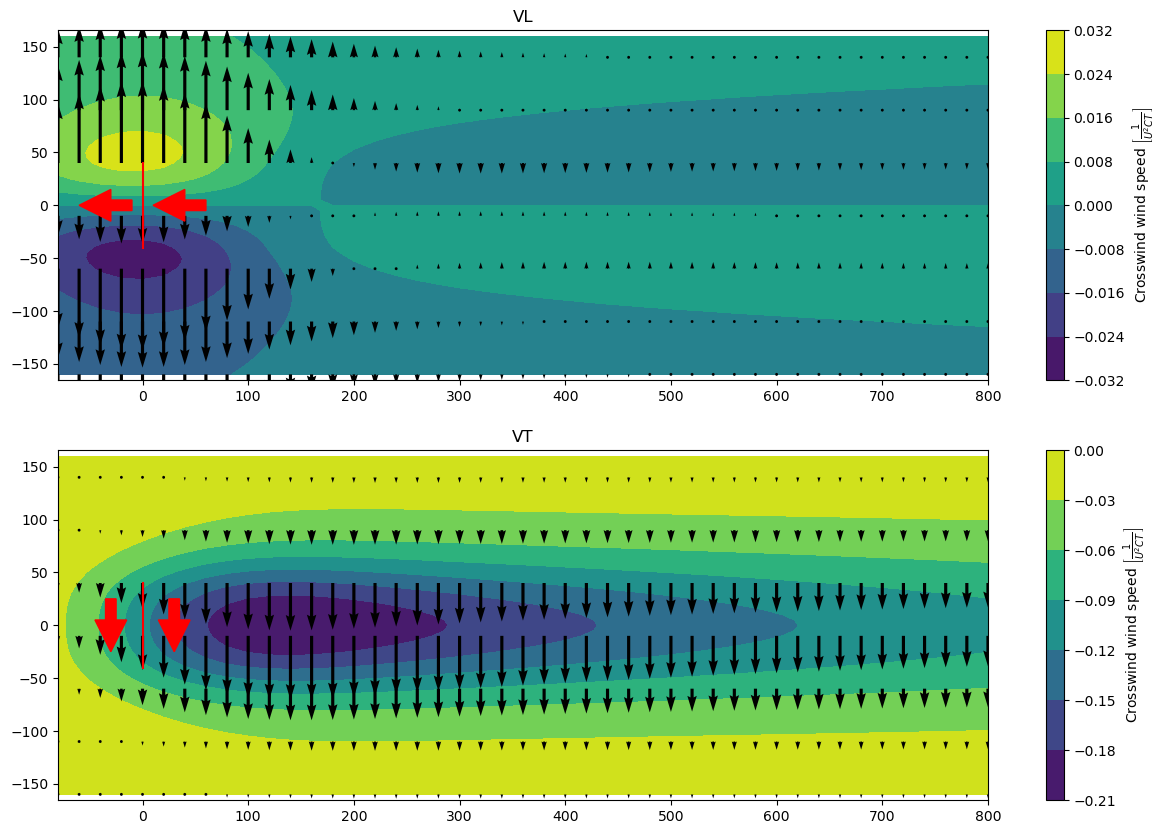

In [37]:
%matplotlib inline
axes = plt.subplots(2,1, figsize=(15,10))[1]
X, Y = np.meshgrid(fugaDeflection.x[xi0:xi1], fugaDeflection.mirror(fugaDeflection.y[:yi], anti_symmetric=True))
for ax, v, l in zip(axes.flatten(), [-VL, VT], ['VL','VT']):
    c = ax.contourf(X, Y, v)
    plt.colorbar(c, ax=ax, label=r'Crosswind wind speed $\left[\frac{1}{U^2 CT}\right]$')
    s = (slice(None,None,10),slice(None,None,1))
    ax.quiver(X[s], Y[s], 0, v[s], scale=(.3,3)[l[1]=='T'])
    ax.plot([0,0],[-D/2,D/2],'r')
    if l[1]=='L':
        ax.arrow(-10,0,-20,0,color='r', width=10,head_length=30)
        ax.arrow(60,0,-20,0,color='r', width=10,head_length=30)
    else:
        ax.arrow(-30,25,0,-20,color='r', width=10,head_length=30)
        ax.arrow(30,25,0,-20,color='r', width=10,head_length=30)
        
    ax.axis('equal')
    ax.set_xlim([-D,10*D])
    ax.set_ylim([-D,D])
    ax.set_title(l) 

**As Fuga is a linear model, the effects in the crosswind direction can simply be calculated by linear superposition of** `VL` **and** `VT`:

$WS_{crosswind} = (VL \cdot cos\theta + VT \cdot sin\theta) \cdot U \cdot CT$

**You can move the slider below to see the crosswind wind speed field for different yaw-misalignment angles. Furthermore, the integrated deflection is shown with solid lines**

In [40]:
%matplotlib notebook
def plot(yaw):
    plt.figure(figsize=(10,4))
    theta = np.deg2rad(yaw)
    co, si = np.cos(theta), np.sin(theta)
    V = co**2*(-VL*co + VT*si)
    X, Y = np.meshgrid(fugaDeflection.x[xi0:xi1], fugaDeflection.mirror(fugaDeflection.y[:yi], anti_symmetric=True))
    c = plt.contourf(X, Y, V)#, levels=np.arange(-.09,.1,.01))
    plt.colorbar(c, label=r'Crosswind wind speed $left[\frac{1}{U^2 CT}\right]$')
    s = (slice(None,None,6),slice(None,None,1))
    plt.quiver(X[s], Y[s], V[s]*0, V[s], width=.002, scale=2)
    
    # plot deflection lines
    fL, fT = fugaDeflection.fLT.V.T[:,256-yi:255+yi, xi0:xi1]
    lambda2p = co**2 * (fL * co - fT * si)
    y = fugaDeflection.mirror(fugaDeflection.y[:yi], anti_symmetric=True)
   
    lambda2 = np.array([np.interp(y, y + l2p, l2p) for l2p in lambda2p.T])
    Yp = Y + lambda2.T
    plt.plot(X[yi, :], Y[yi, :], 'k', lw=1)
   
    
    
    plt.plot([si*R, -si*R],[-co*R,co*R],'w',label='Rotor',lw=3)
    plt.arrow(-0,0,-50*co,0,color='r', width=5,head_length=10,length_includes_head=True, zorder=32)
    plt.arrow(-0,-0,0,-50*si,color='r', width=5,head_length=10,length_includes_head=True, zorder=32)
    plt.axis('equal')
    plt.xlim([-D,10*D])
    plt.ylim([-D,D])
    ax.set_title(l) 
    plt.tight_layout()
_ = interact(plot, yaw=IntSlider(min=-90, max=90, step=1, value=20, continuous_update=False))

interactive(children=(IntSlider(value=20, continuous_update=False, description='yaw', max=90, min=-90), Output…

Note, the plot above shows the wind speed in cross-wind direction (up), i.e. yellow colors corresponds to a flow towards the top of the figure, while blue corresponds to a flow towards the bottom.

**Finally, all effects are put together. You can move the slider below to see the effects on the deficit behind a WT.**

In [21]:
%matplotlib notebook
path = tfp + 'fuga/2MW/Z0=0.00001000Zi=00400Zeta0=0.00E+00.nc'
fugaDeficit = FugaYawDeficit(path)
wfm = All2AllIterative(site,wt,fugaDeficit,blockage_deficitModel=fugaDeficit,                       
                       deflectionModel=FugaDeflection(path)
                       )
def plot(yaw):
    plt.figure(figsize=(10,5))
    fm = wfm([0],[0],ws=10,wd=270, yaw=[[[yaw]]]).flow_map(XYGrid(x=np.arange(-100,800,10), y=np.arange(-250,250,10)))
    X,Y = np.meshgrid(fm.x, fm.y)
    c1 = plt.contourf(X,Y,fm.WS_eff.squeeze(),np.arange(6.5,10.1,0.1), cmap='Blues_r')
    c2 = plt.contourf(X,Y,fm.WS_eff.squeeze(),np.arange(10,10.2,.005), cmap='Reds')
    plt.colorbar(c2, label='Wind speed (deficit regions) [m/s]')
    plt.colorbar(c1, label='Wind speed (speed-up regions) [m/s]')
    wt.plot([0],[0],wd=270,yaw=yaw)
    max_deficit_line = fm.min_WS_eff(x=np.arange(-100,800,10))
    max_deficit_line.plot(color='k', label='Max deficit line')
    plt.axhline(0, label='Center line')
    plt.legend()
    plt.tight_layout()
    
    
_ = interact(plot, yaw=IntSlider(min=-90, max=90, step=1, value=20, continuous_update=False))    

interactive(children=(IntSlider(value=20, continuous_update=False, description='yaw', max=90, min=-90), Output…

Note, the scaling of wake deficit(blue) and speedup(red) are not the same